In [1]:
import numpy as np

import math
import matplotlib.pyplot as plt

from keras.utils import np_utils
from keras.utils import to_categorical
plt.style.use('seaborn')

from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor

import random
import warnings

from sklearn import mixture
from GMM_Conditional import *

Using TensorFlow backend.


In [2]:
# rainbow payoff
def RainbowPayoff(S, K, basketK, bestWorst='best', callPut='call'):
    if bestWorst=='worst' and callPut=='call':
        return np.maximum(np.min(S / K,1) - basketK, 0.0)
    elif bestWorst=='best' and callPut=='put':
        return np.maximum(basketK - np.max(S / K, 1.), 0.0)
    elif bestWorst=='worst' and callPut=='put':
        return np.maximum(basketK - np.min(S / K, 1.), 0.0)
    else:
        return 1. * np.maximum(np.max(S / K,1) - basketK, 0.0)

# derivative of the payoff for dcke comparison
def RainbowPayoffDerivative(S, K, basketK, bestWorst='best', callPut='call'):    
    shape = S.shape
    dim=shape[1]
    numPath=shape[0]
    zeros = np.zeros(shape)
    
    if bestWorst=='worst':
        dummy = np.argmin(S / K,1)
        extS = np.min(S / K,1)
    else:
        dummy = np.argmax(S / K,1)
        extS = np.max(S / K,1)
    
    if callPut=='call':
        argS =  (extS > basketK) * extS
    else:
        argS =  (extS < basketK) * extS

    uniques, ids = np.unique(np.arange(shape[1]), return_inverse=True)
    y_code = np_utils.to_categorical(dummy, len(uniques))
    
    return 1. * argS.repeat(dim).reshape(-1,dim) * y_code / np.array(K).repeat(numPath).reshape(-1,dim)

In [3]:
# Euler scheme for Heston in multiple dimensions
def heston_path_euler_ft(S0, r, T, v0, heston_par, corr, ndim, nsim, nstep):
    """

    param S0: the current spot price of the stock
    param r: the assumed risk-free rate
    param q: the assumed dividend yield
    param v0: spot variance
    param vLong: long term variance
    param kappa: mean reversion of variance
    param sigma: volatility of variance
    param rho: correlation of the driving BMs
    param time_grid: np.array of shape (ntimes,)
    param nsims: number of paths
    param seed: seed for the random number generator
    
    returns: tuple (s, v) where s and v are both np.arrays of shape (ntimes, nsims) containing the stock price 
             and volatility paths 
    """
    vLong = heston_par[0]
    kappa = heston_par[1]
    sigma = heston_par[2]
    
    mean = np.zeros(2*np.size(sigma))
    cov = np.diag(np.diag(np.ones((10,10))))
    
    dW = np.zeros((nstep,nsim,2*ndim))
    #for j in range(nsim):
    for i in range(nstep-1):
        N = np.random.multivariate_normal(mean, cov, nsim)
        chol = np.linalg.cholesky(corr)   
        N = np.matmul(chol,N.T).T
        dW[i,:,:] = N

    
    delta = T/nstep
    sdelta = np.sqrt(delta)
    
    v = np.zeros((nstep,nsim,ndim)) #np.zeros((ndim, ntimes, nsims))
    S = np.zeros((nstep,nsim,ndim))
    
    for i in range(0,ndim):
        v[0,:,i] = v0[i]
        S[0,:,i] = S0[i]
    
    vz = np.zeros_like(v[0,:,0])
    for j in range(ndim):
        for i in range(nstep-1):
            var = v[i,:,j]
            vs = np.sqrt(var) * sdelta
            v[i+1,:,j] = var + kappa[j] * (vLong[j] - var) * delta + vs * sigma[j] * dW[i, :, ndim+j]
            v[i+1,:,j] = np.maximum(v[i+1, :, j], -v[i+1, :, j])#vz)
            S[i+1,:,j] = S[i, :, j] * np.exp((r[j] - 0.5 * var) * delta + vs * dW[i, :, j])

    return S, v

In [4]:
# correlation matrix for a 5d Heston, ie. a 10d model
# the final matrix will be derived by completing the correlation matrix - Günther/Kahl method
dim = 5
corr_S = np.ones((dim,dim))
# asset correlation
# S0, S1
corr_S[0,1] = 0.2
corr_S[1,0] = corr_S[0,1]
# S0, S2
corr_S[0,2] = 0
corr_S[2,0] = corr_S[0,2]
# S0, S3
corr_S[0,3] = 0.5
corr_S[3,0] = corr_S[0,3]
# S0, S4
corr_S[0,4] = 0.7
corr_S[4,0] = corr_S[0,4]
# S1, S2
corr_S[1,2] = 0.4
corr_S[2,1] = corr_S[1,2]
# S1, S3
corr_S[1,3] = 0
corr_S[3,1] = corr_S[1,3]
# S1, S4
corr_S[1,4] = 0.1
corr_S[4,1] = corr_S[1,4]
# S2, S3
corr_S[2,3] = 0.3
corr_S[3,2] = corr_S[2,3]
# S2, S4
corr_S[2,4] = 0.2
corr_S[4,2] = corr_S[2,4]
# S3, S4
corr_S[3,4] = 0.25
corr_S[4,3] = corr_S[3,4]

vec_vS = np.array([-.7, -.8, -.9, -.8, -.3]) # asset variance correlation
corr_vS = np.diag(vec_vS)
vec_v = np.ones(dim)                    # variance variance correlation
corr_v = np.diag(vec_v)
corr_v_org = np.diag(vec_v)

# complete the correlation matrix
for j in range(1,dim):
    d = np.multiply(corr_S[:dim-j,dim-j],vec_vS[1:dim-j+1])
    corr_vS[:dim-j, dim-j] = d
    corr_vS[dim-j ,:dim-j] = d
for j in range(1,dim):
    d = np.multiply(vec_vS[:dim-j],corr_vS[:dim-j,dim-j])
    corr_v[:dim-j,dim-j] = d
    corr_v[dim-j,:dim-j] = d
#print("variance correlation completed: \n", corr_v)

corr = np.ones((2*dim,2*dim))
corr[:dim,:dim] = corr_S
corr[:dim,dim:2*dim] = corr_vS
corr[dim:2*dim,dim:2*dim] = corr_v
corr[dim:3*dim,:dim] = corr_vS.transpose()

print(corr)

[[ 1.     0.2    0.     0.5    0.7   -0.7   -0.16  -0.    -0.4   -0.56 ]
 [ 0.2    1.     0.4    0.     0.1   -0.16  -0.8   -0.36  -0.    -0.09 ]
 [ 0.     0.4    1.     0.3    0.2   -0.    -0.36  -0.9   -0.24  -0.16 ]
 [ 0.5    0.     0.3    1.     0.25  -0.4   -0.    -0.24  -0.8   -0.075]
 [ 0.7    0.1    0.2    0.25   1.    -0.56  -0.09  -0.16  -0.075 -0.3  ]
 [-0.7   -0.16  -0.    -0.4   -0.56   1.     0.112  0.     0.28   0.392]
 [-0.16  -0.8   -0.36  -0.    -0.09   0.112  1.     0.288  0.     0.072]
 [-0.    -0.36  -0.9   -0.24  -0.16   0.     0.288  1.     0.216  0.144]
 [-0.4   -0.    -0.24  -0.8   -0.075  0.28   0.     0.216  1.     0.06 ]
 [-0.56  -0.09  -0.16  -0.075 -0.3    0.392  0.072  0.144  0.06   1.   ]]


In [5]:
# check if the result is positive definite... Of course it is ;-)
#np.linalg.cholesky(corr)

In [6]:
# 5d Heston case
S0 = np.array([100., 100., 100., 100., 100.])
v0 = np.array([0.03, 0.02, 0.023, 0.04, 0.03])
kappa = np.array([0.1, 0.13, 0.2, 0.21, 0.15])
sigma = np.array([0.2, 0.23, 0.3, 0.14, 0.3])
vLong = np.array([0.032, 0.026, 0.023, 0.02, 0.024])

heston_par = [kappa, sigma, vLong]

rate = np.array([0.03, 0.03, 0.03, 0.03, 0.03])
T = 1
dts = np.linspace(0,1,3)

In [7]:
ndim = 5
nstep = 3
nsim = 10000
[S, V] = heston_path_euler_ft(S0, rate, T, v0, heston_par, corr, ndim, nsim, nstep)

In [8]:
# define the pricing functions for the rainbow case

def PriceRainbowNDimH(S0, rate, T, v0, heston_par, corr, ndim, nsim, nstep, K, basketK, callPut='call'):
    # with internal simulation
    (simS, W) = heston_path_euler_ft(S0, rate, T, v0, heston_par, corr, ndim, nsim, nstep)
    payoff = RainbowPayoff(simS[-1], K, basketK,callPut=callPut)
    return np.exp(-rate[0]*T)*np.average(payoff)

def PriceRainbowNDimH1(S0, rate, T, v0, heston_par, corr, ndim, nsim, nstep, K, basketK, simS, callPut='call'):
    # with feeding path set
    payoff = RainbowPayoff(simS[-1], K, basketK,callPut=callPut)
    return np.exp(-rate[0]*T)*np.average(payoff)

def PriceRainbowNDimDeltasH(S0, rate, T, v0, heston_par, corr, ndim, nsim, nstep, K, basketK, callPut='call'):
    # with internal simulation
    eps = 0.01
    dimS = len(S0)
    out = []
    basePrice = PriceRainbowNDimH(S0, rate, T, v0, heston_par, corr, ndim, nsim, nstep, K, basketK, callPut='call')
    delta = np.zeros(dimS)
    nruns = 1
    for j in range(nruns):
        for i in range(dimS):
            SShock = S0
            SShock[i] += eps
            shockPrice = PriceRainbowNDimH(SShock, rate, T, v0, heston_par, corr, ndim, nsim, nstep, K, basketK, callPut='call')
            delta[i] = delta[i] + (shockPrice-basePrice)/eps #out.append((shockPrice-basePrice)/eps)
    return delta/nruns #np.array(out)

def PriceRainbowNDimDeltasH1(S0, rate, T, v0, heston_par, corr, ndim, nsim, nstep, K, basketK, simS, callPut='call'):
    # with feeding path set and one other internal simulation for the finite difference estimator
    eps = 0.01
    dimS = len(S0)
    out = []
    basePrice = PriceRainbowNDimH1(S0, rate, T, v0, heston_par, corr, ndim, nsim, nstep, K, basketK, simS,callPut='call')
    delta = np.zeros(dimS)
    nruns = 1
    for j in range(nruns):
        for i in range(dimS):
            SShock = S0
            SShock[i] += eps
            shockPrice = PriceRainbowNDimH(SShock, rate, T, v0, heston_par, corr, ndim, nsim, nstep, K, basketK, callPut='call')
            delta[i] = delta[i] + (shockPrice-basePrice)/eps #out.append((shockPrice-basePrice)/eps)
    return delta/nruns #np.array(out)

In [9]:
# test
K = np.ones(5) * 100.
basketK = .9

price = PriceRainbowNDimH(S0, rate, T, v0, heston_par, corr, ndim, nsim, nstep, K, basketK, callPut='call')
delta = PriceRainbowNDimDeltasH(S0, rate, T, v0, heston_par, corr, ndim, nsim, nstep, K, basketK, callPut='call')

print(price)
print(delta)

0.26522316338875324
[0.32942021 0.10727279 0.09016074 0.37706621 0.01770343]


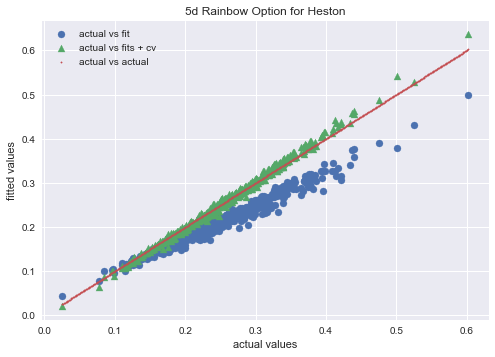

(0.04015126616254959, 0.005204268215378793)

In [10]:
# Rainbow option with DCKE, see "Dynamically Controlled Kernel Estimation", Geng, Kienitz, Lee, Nowaczyk, SSRN 2021
# this method uses a kernel density estimator (Nadarya Watson, resp. local linear) with variable bandwidth
# together with a control variate to compute delta and an enhance estimator
dimS = 5
sampleCov = np.zeros((dim,dim))
np.fill_diagonal(sampleCov,np.var(S[-1]-S[-2],0))
invSampleCov = np.linalg.pinv(sampleCov)
sampleL = np.linalg.cholesky(invSampleCov) * (4.0 / nsim*(dimS + 2.0))**((1.0/(dimS + 4.0)))
sampleL *= 1.4

nsim_inner = 1000
nCalibrate = 500

# using new values to calibrate
# from torch.quasirandom import SobolEngine
#engine = SobolEngine(len(S0), scramble=False, seed=None)
#draws = engine.draw(nDraws)
#samples = []
#for draw in draws:
#    samples.append(np.percentile(S[1], 100*draw))
#samples = np.array(samples) 

# using existing values already simulated
idx_sample = random.sample(range(nsim), nCalibrate)
samples = S[1][idx_sample]

   
    
actuals = []
actualDerivs = []
fits = []
derivs = []
s2avgs = []

payoff= RainbowPayoff(S[-1],K,basketK)
payoffDeriv=RainbowPayoffDerivative(S[-1], K, basketK)


kout = []
for idx, sample in enumerate(samples):
    tileStart = np.tile(sample, nsim).reshape(-1,len(S0))
    k=np.exp(-np.sum(((S[-1] - tileStart)@sampleL)**2,1))+1e-15
    kout.append(np.sum(k))

kRatio = np.minimum(100.0, max(kout) / kout)

dt = dts[-1]-dts[-2]
for idx, sample in enumerate(samples):
    actual = PriceRainbowNDimH(sample, rate, dt, v0, heston_par, corr, ndim, nsim_inner, nstep, K, basketK,callPut='call')
    actualDeriv = PriceRainbowNDimDeltasH(sample, rate, T, v0, heston_par, corr, ndim, nsim_inner, nstep, K, basketK, callPut='call')
    
    tileStart = np.tile(sample, nsim).reshape(-1,len(S0))
    k=np.exp(-np.sum(((S[-1] - tileStart)@sampleL)**2,1))+1e-15
    k*=kRatio[idx]
    tileK = np.tile(k, len(S0)).reshape(len(S0),-1).T
    fit = np.sum(k*payoff)/np.sum(k)
    deriv = np.sum(tileK*payoffDeriv,0)/np.sum(k)
    
    s2avg = np.sum(tileK*S[2],0) / np.sum(k)
    s2avg *= math.exp(-rate[0]*(dts[2] - dts[1]))
    s2avgs.append(s2avg)

    derivs.append(deriv)
    actuals.append(actual)
    actualDerivs.append(actualDeriv)
    fits.append(fit)

fits_cv = fits+np.sum(derivs * (samples - s2avgs),1)

diagonal = np.linspace(np.min(actuals),np.max(actuals),len(actuals))
fig, ax = plt.subplots()
ax.scatter(actuals, fits, label = 'actual vs fit')
ax.scatter(actuals, fits_cv, marker='^', label = 'actual vs fits + cv')
ax.scatter(diagonal,diagonal, s=2,label='actual vs actual')

ax.legend()
ax.set_title('5d Rainbow Option for Heston')
ax.set_xlabel('actual values')
ax.set_ylabel('fitted values')
plt.show()

np.average(np.abs(np.array(actuals) - fits)), np.average(np.abs(np.array(actuals) - (fits_cv)))

#fig.savefig('rainbow_5d_heston_cv.pdf')

In [11]:
# transforms that we apply to the spots, resp option prices
def tprice(x, choice):
    if choice == 0:
        return x
    else:
        return np.log(x + 1.01)

def itprice(x, choice):
    if choice == 0:
        return x
    else:
        return np.exp(x) - 1.01

def tspot(x, choice):
    if choice == 0:
        return x
    else:
        return np.log(x)

def itspot(x, choice):
    if choice == 0:
        return x
    else:
        return np.exp(x)

In [12]:
t_price = 1
t_spot = 1

In [13]:
# marginals at time t and T
S1t = tspot(S[1][:,0], t_spot)
S2t = tspot(S[1][:,1], t_spot)
S3t = tspot(S[1][:,2], t_spot)
S4t = tspot(S[1][:,3], t_spot)
S5t = tspot(S[1][:,4], t_spot)
St = [S1t, S2t, S3t, S4t, S5t]

S1T = tspot(S[2][:,0], t_spot)
S2T = tspot(S[2][:,1], t_spot)
S3T = tspot(S[2][:,2], t_spot)
S4T = tspot(S[2][:,3], t_spot)
S5T = tspot(S[2][:,4], t_spot)
ST = [S1T, S2T, S3T, S4T, S5T]


# option prices at t and T
OT = tprice(RainbowPayoff(S[2],K,basketK),t_price)

prices = []
simS = heston_path_euler_ft(S0, rate, T, v0, heston_par, corr, ndim, nsim, nstep)
for s in S[1]:
#    prices.append(PriceRainbowNDimH(s, rate, dt, v0, heston_par, corr, ndim, nsim, nstep, K, basketK, callPut='call'))
    prices.append(PriceRainbowNDimH1(s, rate, dt, v0, heston_par, corr, ndim, nsim, nstep, K, basketK, simS,callPut='call'))
    
Ot = np.asarray(prices)

df = math.exp(-rate[0]*(dts[2] - dts[1]))

In [14]:
# calculate beta (ie. delta) conditionally on CV
# theses functions are used in the calculations below
def calcdelta(mu, cov, weights):
    covar_cond_w = []
    i = 0
    for w in weights:
        covar_cond_w.append(w * cov[i])
        i = i + 1

    c = np.sum(covar_cond_w, axis = 0)
    
    return c[0,1] / c[0,0]

# calculate the means conditionally on CV
def calcm(mu, cov, weights):
    mu_cond_w = []
    i = 0
    for w in weights:
        mu_cond_w.append(w * mu[i])
        i = i + 1
    
    m = np.sum(mu_cond_w, axis = 0)
    
    return m[0],  m[1]


# calculate the means conditionally on CV
def calcm1(mu, cov, weights):
    mu_cond_w = []
    i = 0
    for w in weights:
        mu_cond_w.append(w * mu[i])
        i = i + 1
    
    m = np.sum(mu_cond_w, axis = 0)
    
    return m

In [15]:
# fit a Gaussian and calculate the conditional expectation analytically
# for the conditioning using a control variate
# this is the same as for the DCKE but replacing the kernel density estimator with GMM
# this results in all calculations are analytic!!!
# Just the parameters for the GMM need to be calculated numerically with EM algorithm

ngmm = 5                                # number of mixture distributions


# first estimate the mean
X_estimate = np.vstack((OT,S1t, S2t, S3t, S4t, S5t)).T   # set up the training set

# init a Gaussian Mixture model with ngmm components on the training data
gmm_x = mixture.GaussianMixture(n_components=ngmm).fit(X_estimate)

# calculate the conditional distribution based on mixtures
gmm_cond_estimate = GMM_Conditional(means=gmm_x.means_,
                           covariances=gmm_x.covariances_,
                           weights=gmm_x.weights_,
                           n_components=gmm_x.n_components,
                           D1=1, D2=5)

Sk1T = tspot(S[2][:,0]/K[0],t_spot)
Sk2T = tspot(S[2][:,1]/K[1],t_spot)
Sk3T = tspot(S[2][:,2]/K[2],t_spot)
Sk4T = tspot(S[2][:,3]/K[3],t_spot)
Sk5T = tspot(S[2][:,4]/K[4],t_spot)
SkT = [Sk1T, Sk2T, Sk3T, Sk4T, Sk5T]
SkT = np.asarray(SkT)


# different control variates (min and max)
X_max = np.vstack((np.maximum.reduce(SkT), OT, S1t, S2t, S3t, S4t, S5t)).T   # set up the training set
X_min = np.vstack((np.minimum.reduce(SkT), OT, S1t, S2t, S3t, S4t, S5t)).T   # set up the training set

# init a Gaussian Mixture model with ngmm components on the training data
gmm_max = mixture.GaussianMixture(n_components=ngmm).fit(X_max)
gmm_min = mixture.GaussianMixture(n_components=ngmm).fit(X_min)

# calculate the conditional distribution based on mixtures
gmm_cond_max = GMM_Conditional(means=np.flipud(gmm_max.means_),
                             covariances=np.flipud(gmm_max.covariances_),
                             weights=np.flipud(gmm_max.weights_),
                             n_components=gmm_max.n_components,
                             D1=2, D2=5)

gmm_cond_min = GMM_Conditional(means=np.flipud(gmm_min.means_),
                             covariances=np.flipud(gmm_min.covariances_),
                             weights=np.flipud(gmm_min.weights_),
                             n_components=gmm_min.n_components,
                             D1=2, D2=5)

In [16]:
#Srange_m = samples
Srange_m = tspot(samples, t_spot) 

In [17]:
# estimate the results form the training and the GMM
i = 0
mu = []

Srange = Srange_m
for s in Srange:
    mu_cond, covar_cond, weights_cond = gmm_cond_estimate.par_x1_cond_x2(s)
    i = i + 1
    mu.append(calcm1(mu_cond, covar_cond, weights_cond))
    
# maximum/minimum as cv
Srange = Srange_m 

i = 0
mu_max = []
mu_min = []

for s in Srange:
    mu_cond, covar_cond, weights_cond = gmm_cond_max.par_x1_cond_x2(np.maximum.reduce(s))
    mu_max.append(calcm1(mu_cond, covar_cond, weights_cond))
    mu_cond, covar_cond, weights_cond = gmm_cond_min.par_x1_cond_x2(np.minimum.reduce(s))
    mu_min.append(calcm1(mu_cond, covar_cond, weights_cond))
    i = i + 1
    
mu_max = itprice(np.asarray(mu_max), t_price)
mu_min = itprice(np.asarray(mu_min), t_price)



In [18]:
#mu = np.asarray(mu)
mu_org = mu
mu = itprice(np.asarray(mu),t_price)
mu_hybrid = np.asarray(mu[:,0]) + np.sum(derivs * (samples - s2avgs),1)

In [19]:
np.max(mu_hybrid), np.max(mu)

(0.6633499105361607, 0.5261670671081553)

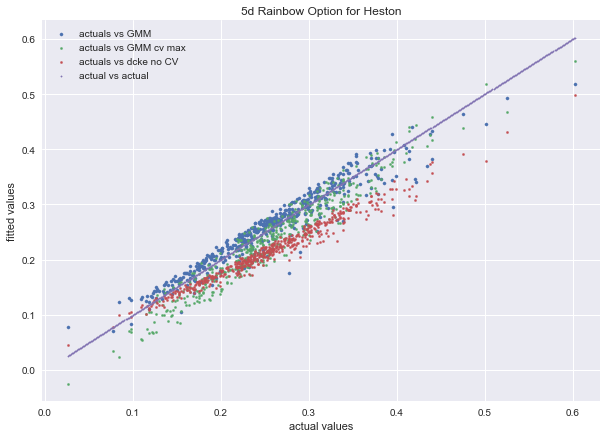

In [20]:
#plt.scatter(Ot, mu)
#plt.title("GMM estimate vs calculated option price")
#diagonal = np.linspace(np.min(Ot),np.max(Ot),len(Ot))
diagonal = np.linspace(np.min(actuals),np.max(actuals),len(actuals))
fig, ax = plt.subplots(figsize=[10,7])

#ax.scatter(Ot, mu,1, label = 'actuals vs GMM')
ax.scatter(actuals, np.asarray(mu) * df,10, label = 'actuals vs GMM')
#ax.scatter(actuals, np.asarray(mu_hybrid) * df,10, label = 'actuals vs GMM hybrid')
ax.scatter(actuals, mu_max[:,0]*df,5, label = 'actuals vs GMM cv max')
ax.scatter(actuals, fits,5, label = 'actuals vs dcke no CV')
#ax.scatter(actuals, fits_cv,10, label = 'actuals vs dcke CV')
ax.scatter(diagonal,diagonal, s=2, label = 'actual vs actual')

ax.legend()
ax.set_title('5d Rainbow Option for Heston')
ax.set_xlabel('actual values')
ax.set_ylabel('fitted values')
#ax.set_ylim([0,50])
plt.show()

In [21]:
# gmm dcke
gmm_list = []
gmm_cond_list = []

for sval in ST:
    X = np.vstack((sval, OT, S1t, S2t,S3t,S4t, S5t)).T #np.vstack((sval, OT, np.asarray(St))).T
    model = mixture.GaussianMixture(n_components=ngmm).fit(X)
    cond_model = GMM_Conditional(means=np.flipud(model.means_),
                             covariances=np.flipud(model.covariances_),
                             weights=np.flipud(model.weights_),
                             n_components=model.n_components,
                             D1=2, D2=5)
    
    gmm_list.append(model)
    gmm_cond_list.append(cond_model)

In [22]:
model_list = gmm_cond_list#[gmm_cond_1, gmm_cond_2,gmm_cond_3,gmm_cond_4,gmm_cond_5]
glist_mu = []
glist_delta = []

j = 0
for m in model_list:
    Srange = Srange_m[:,j]
    i = 0
    llist_mu = []
    llist_delta = []
    for s in Srange:
        mu_cond, covar_cond, weights_cond = m.par_x1_cond_x2(s)
        llist_mu.append(calcm1(mu_cond, covar_cond, weights_cond))
        llist_delta.append(calcdelta(mu_cond, covar_cond, weights_cond))
        i = i + 1
    glist_mu.append(np.asarray(llist_mu))
    glist_delta.append(np.asarray(llist_delta))
    j = j+1
    
garray_mu = np.asarray(glist_mu)
garray_delta = np.asarray(glist_delta)


CV_c = np.zeros(len(Srange_m[:,0]))
i = 0
for d, m in zip(garray_delta, garray_mu):
    CV_c += d * (Srange_m[:,i] - m[:,0])
    i = i + 1


In [23]:
# delta for cv
#Srange = tspot(samples/K, t_spot)
i=0
delta_max = []
delta_min = []
for s in Srange:
    mu_cond, covar_cond, weights_cond = gmm_cond_max.par_x1_cond_x2(np.maximum.reduce(s))
    delta_max.append(calcdelta(mu_cond, covar_cond, weights_cond))
    mu_cond, covar_cond, weights_cond = gmm_cond_min.par_x1_cond_x2(np.minimum.reduce(s))
    delta_min.append(calcdelta(mu_cond, covar_cond, weights_cond))
    i = i + 1
    
delta_max = np.asarray(delta_max)
delta_min = np.asarray(delta_min)  

In [24]:
MU = np.asarray(mu)
leverage = .9

V_panda = itprice(np.asarray(mu_org)[:,0] + leverage * CV_c,t_price)

In [25]:
MU_max = np.asarray(mu_max)
MU_min = np.asarray(mu_min)
l_max = 0.2
l_min = 0.0
CV_c_max = l_max * (np.maximum.reduce(Srange_m/K, axis = 1) - mu_max[:,0])   
CV_c_min = l_min * (np.minimum.reduce(Srange_m/K, axis = 1) - mu_min[:,0])   


#CV_correction_max = CV_correction_max
V_panda_max = itprice(MU[:,0]  +  CV_c_max, t_price)
V_panda_min = itprice(MU[:,0]  +  CV_c_min, t_price)

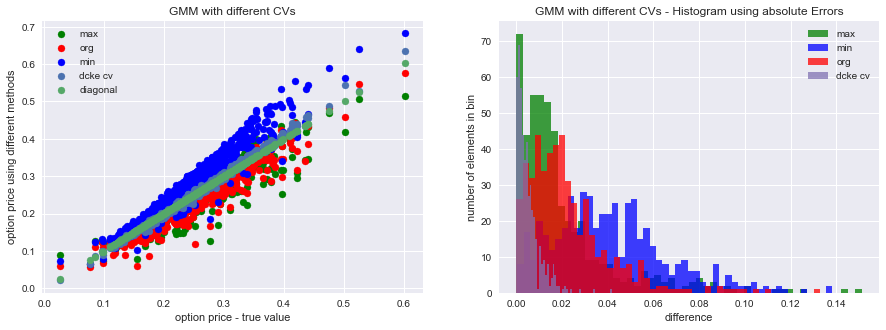

In [26]:
title_str = "gmm-dcke_cv_5dHeston_rainbow_CVs" + str(dt) + "_ngmm_" + str(ngmm) + ".pdf"

fig, (ax1, ax2) = plt.subplots(1,2, figsize = [15,5])

ax1.scatter(actuals, V_panda_max, label = "max", color = "g")
ax1.scatter(actuals, V_panda, label = "org", color = "r")
ax1.scatter(actuals, V_panda_min, label = "min", color = "b")
ax1.scatter(actuals, fits_cv, label = "dcke cv")
ax1.scatter(actuals, actuals, label = "diagonal")
ax1.set_title('GMM with different CVs')
ax1.set_xlabel('option price - true value')
ax1.set_ylabel('option price using different methods')
ax1.legend()

n1,bins1,patches1 = ax2.hist(np.abs(actuals-V_panda_max), 50, label = "max", density=False, facecolor='g', alpha=0.75)
n3,bins3,patches3 = ax2.hist(np.abs(actuals-V_panda_min), 50, label = "min", density=False, facecolor='b', alpha=0.75)
n2,bins2,patches2 = ax2.hist(np.abs(actuals-V_panda), 50, label = "org", density=False, facecolor='r', alpha=0.75)
n,bins,patches = ax2.hist(np.abs(actuals-fits_cv), 50, label = "dcke cv", density=False, alpha=0.75)
ax2.set_title('GMM with different CVs - Histogram using absolute Errors')
ax2.set_xlabel("difference")
ax2.set_ylabel("number of elements in bin")
ax2.legend()

#plt.savefig(title_str)

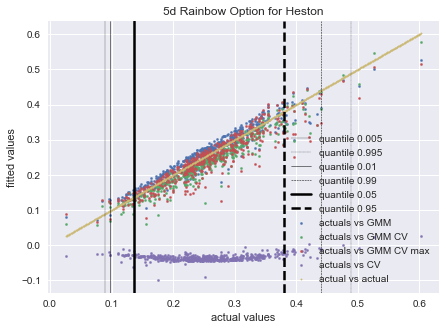

In [27]:
title_str = "gmm-dcke_cv_5dHeston_rainbow_" + str(dt) + "_ngmm_" + str(ngmm) + ".pdf"
quantile_list = [0.005, 0.01, 0.05]

diagonal = np.linspace(np.min(actuals),np.max(actuals),len(actuals))

fig, ax = plt.subplots(figsize = (7,5))

ax.scatter(actuals, itprice(np.asarray(mu_org)[:,0], t_price),5, label = 'actuals vs GMM')
ax.scatter(actuals, V_panda,5, label = 'actuals vs GMM CV')
ax.scatter(actuals, V_panda_max,5, label = 'actuals vs GMM CV max')
ax.scatter(actuals, itprice(CV_c, t_price),5, label = 'actuals vs CV')
ax.scatter(diagonal,diagonal, 2, label = 'actual vs actual')

ax.set_title('5d Rainbow Option for Heston')
ax.set_xlabel('actual values')
ax.set_ylabel('fitted values')
for q in quantile_list:
    ax.axvline(x=np.quantile(actuals,q), linestyle="-", c = 'black', lw = q*50, label = "quantile " + str(q))
    ax.axvline(x=np.quantile(actuals,1-q), linestyle="--", c = 'black', lw = q * 50, label = "quantile " + str(1-q))
ax.legend()

#plt.savefig(title_str)

plt.show()

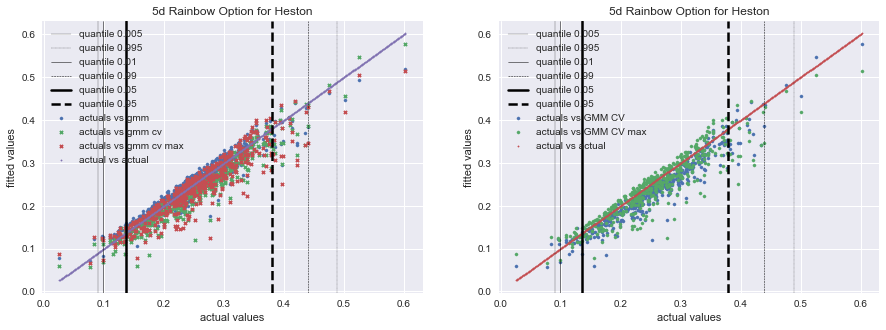

In [28]:
title_str = "gmm-dcke_5dHeston_rainbow_" + str(dt) + "_ngmm_" + str(ngmm) + ".pdf"

quantile_list = [0.005, 0.01, 0.05]
diagonal = np.linspace(np.min(actuals),np.max(actuals),len(actuals))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

#ax.scatter(Ot, mu,1, label = 'actuals vs GMM')
ax1.scatter(actuals, itprice(mu_org, t_price) * df, s = 10, marker = 'o', label = 'actuals vs gmm')
ax1.scatter(actuals, V_panda, s = 10, marker = 'x', label = 'actuals vs gmm cv')
ax1.scatter(actuals, V_panda_max, s = 10, marker = 'x', label = 'actuals vs gmm cv max')
ax1.scatter(diagonal,diagonal, s=2, label = 'actual vs actual')

ax1.set_title('5d Rainbow Option for Heston')
ax1.set_xlabel('actual values')
ax1.set_ylabel('fitted values')
for q in quantile_list:
    ax1.axvline(x=np.quantile(actuals,q), linestyle="-", c = 'black', lw = q*50, label = "quantile " + str(q))
    ax1.axvline(x=np.quantile(actuals,1-q), linestyle="--", c = 'black', lw = q * 50, label = "quantile " + str(1-q))
ax1.legend()


ax2.scatter(actuals, V_panda,10, label = 'actuals vs GMM CV')
ax2.scatter(actuals, V_panda_max,10, label = 'actuals vs GMM CV max')
ax2.scatter(diagonal,diagonal, s=2, label = 'actual vs actual')


ax2.set_title('5d Rainbow Option for Heston')
ax2.set_xlabel('actual values')
ax2.set_ylabel('fitted values')
for q in quantile_list:
    ax2.axvline(x=np.quantile(actuals,q), linestyle="-", c = 'black', lw = q * 50, label = "quantile " + str(q))
    ax2.axvline(x=np.quantile(actuals,1-q), linestyle="--", c = 'black', lw = q * 50, label = "quantile " + str(1-q))
ax2.legend()

#plt.savefig(title_str)


plt.show()

In [29]:
# generate new samples for the test set
[ssamplesValids, VValids] = heston_path_euler_ft(S0, rate, T, v0, heston_par, corr, ndim, nsim, nstep)

idx_sample = random.sample(range(nsim), nCalibrate)
samplesValids = ssamplesValids[1][idx_sample]

In [30]:
###### Fitting the surface using GPR and validate using a different set
# Instantiate a Gaussian Process model, with an initial alpha of the full payoff sample std dev
kernel = ConstantKernel(1.0, (1e-3, 1e10)) * Matern(100, (1e-3, 1e10))
gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimaton of the parameters
gp.fit(samples, fits_cv)           # dcke with cv
#gp.fit(samples,  fits)            # dcke plain

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, gp_sigma = gp.predict(samplesValids, return_std=True)



C:\Users\KienitzJoerg\anaconda3\envs\ML_3_6\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [31]:
actualValids=[]

for sampleValid in samplesValids:
    actualValids.append(PriceRainbowNDimH(sampleValid, rate, dt, v0, heston_par, corr, ndim, nsim, nstep, K, basketK, callPut='call'))
    

In [32]:
# GPR for GMM
# Instantiate a Gaussian Process model, with an initial alpha of the full payoff sample std dev
kernel_gmm = ConstantKernel(1.0, (1e-3, 1e10)) * Matern(100, (1e-3, 1e10))
kernel_gmm_m = ConstantKernel(1.0, (1e-3, 1e10)) * Matern(100, (1e-3, 1e10))

gp_gmm = GaussianProcessRegressor(kernel=kernel_gmm,n_restarts_optimizer=10)        # gmm-dcke standard cv
gp_gmm_m = GaussianProcessRegressor(kernel=kernel_gmm_m,n_restarts_optimizer=10)    # gmm-dcke max as cv

# Fit to data using Maximum Likelihood Estimaton of the parameters
gp_gmm.fit(samples, V_panda)
gp_gmm_m.fit(samples, V_panda_max)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred_gmm, gp_sigma_gmm = gp_gmm.predict(samplesValids, return_std=True)
y_pred_gmm_m, gp_sigma_gmm_m = gp_gmm_m.predict(samplesValids, return_std=True)

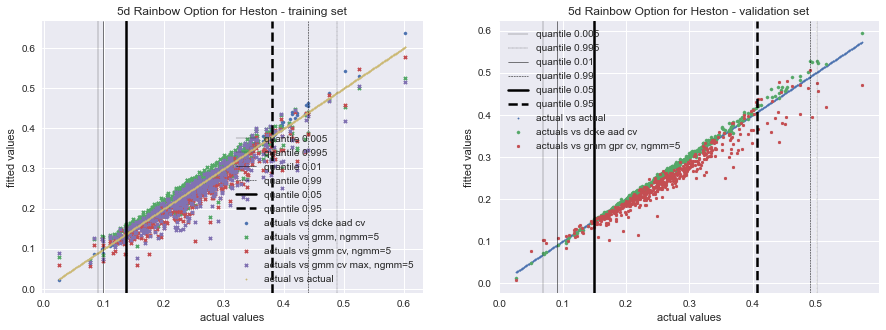

In [33]:
title_str = "gmm-dcke_5dHeston_rainbow_test_val" + str(dt) + "_ngmm_" + str(ngmm) + ".pdf"

quantile_list = [0.005, 0.01, 0.05]
diagonal1 = np.linspace(np.min(actuals),np.max(actuals),len(actuals))
diagonal2 = np.linspace(np.min(actualValids),np.max(actualValids),len(actualValids))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.scatter(actuals, fits_cv, s=10, marker = 'o', label = 'actuals vs dcke aad cv')
ax1.scatter(actuals, itprice(mu_org,t_price), s=10, marker = 'x', label = "actuals vs gmm, ngmm=" + str(ngmm))
ax1.scatter(actuals, V_panda, s=10, marker = 'x', label = "actuals vs gmm cv, ngmm=" + str(ngmm))
ax1.scatter(actuals, V_panda_max, s=10, marker = 'x', label = "actuals vs gmm cv max, ngmm=" + str(ngmm))
ax1.scatter(diagonal1,diagonal1, s=2, label = 'actual vs actual')
ax2.scatter(diagonal2,diagonal2, s=2, label = 'actual vs actual')


ax1.set_title('5d Rainbow Option for Heston - training set')
ax1.set_xlabel('actual values')
ax1.set_ylabel('fitted values')
for q in quantile_list:
    ax1.axvline(x=np.quantile(actuals,q), linestyle="-", c = 'black', lw = q*50, label = "quantile " + str(q))
    ax1.axvline(x=np.quantile(actuals,1-q), linestyle="--", c = 'black', lw = q * 50, label = "quantile " + str(1-q))
ax1.legend()

ax2.scatter(actualValids, y_pred, s=10, marker = 'o', label = 'actuals vs dcke aad cv')
ax2.scatter(actualValids, y_pred_gmm, s=5, marker = 'x', label = 'actuals vs gmm gpr cv, ngmm=' + str(ngmm))
ax2.set_title('5d Rainbow Option for Heston - validation set')
ax2.set_xlabel('actual values')
ax2.set_ylabel('fitted values')
for q in quantile_list:
    ax2.axvline(x=np.quantile(actualValids,q), linestyle="-", c = 'black', lw = q*50, label = "quantile " + str(q))
    ax2.axvline(x=np.quantile(actualValids,1-q), linestyle="--", c = 'black', lw = q * 50, label = "quantile " + str(1-q))
ax2.legend()

#plt.savefig(title_str)


plt.show()

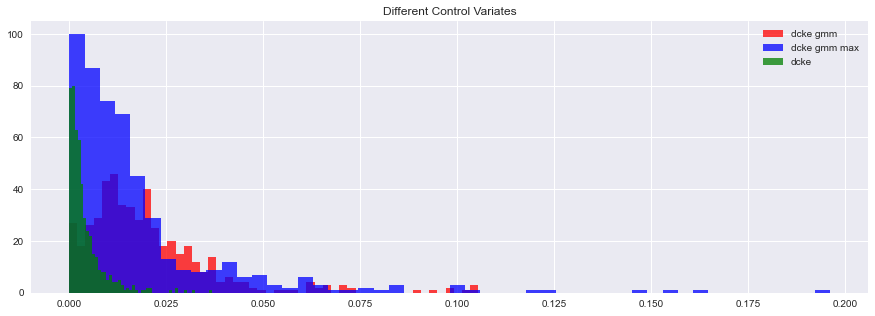

In [34]:
fig, ax = plt.subplots(figsize=(15,5))

n,bins,patches = ax.hist(np.abs(actualValids-y_pred_gmm), 50, label = "dcke gmm", density=False, facecolor='r', alpha=0.75)
n,bins,patches = ax.hist(np.abs(actualValids-y_pred_gmm_m), 50, label = "dcke gmm max", density=False, facecolor='b', alpha=0.75)
n,bins,patches = ax.hist(np.abs(actualValids-y_pred), 50, label = "dcke", density=False, facecolor='g', alpha=0.75)
ax.set_title("Different Control Variates")
ax.legend()

In [35]:
q_list = [0.001, 0.01, 0.05, 0.95, 0.99, 0.99]
for q in q_list:
    print(q, np.quantile(np.abs(actualValids-y_pred_gmm),q), np.quantile(np.abs(actualValids-y_pred_gmm_m),q), np.quantile(np.abs(actualValids-y_pred),q))

0.001 6.354314387712001e-05 8.398590492573827e-05 4.0284428077497436e-05
0.01 0.00031141472043721724 0.00022784564007571756 0.00012552067015357494
0.05 0.0020473737617532017 0.0009319695934280282 0.000291256721689577
0.95 0.04875173554802842 0.05916113145938473 0.012883293894610105
0.99 0.097067927413969 0.11779766685883378 0.026288734264633504
0.99 0.097067927413969 0.11779766685883378 0.026288734264633504
